In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Set up visualization styles
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')

# Load the dataset
# The dataset is delimited by semicolons, so we specify 'sep=';'
df = pd.read_csv('Camp_Market.csv', sep=';')

# --- Data Cleaning and Preprocessing ---

# Drop irrelevant columns as specified in the prompt
df = df.drop(columns=['Z_CostContact', 'Z_Revenue'])

# Fill missing values in 'Income' with the mean income
df['Income'] = df['Income'].fillna(df['Income'].mean())

# Convert 'Dt_Customer' to datetime objects
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

In [5]:
# --- Feature Engineering ---

# Calculate customer's age from birth year
df['Age'] = 2015 - df['Year_Birth']

# Calculate the number of days since the customer's enrollment with the company
df['Tenure_Days'] = (pd.to_datetime('2015-01-01') - df['Dt_Customer']).dt.days

# Calculate total spending and total purchases
spending_cols = [
    'MntWines', 'MntFruits', 'MntMeatProducts', 
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]
df['Total_Spending'] = df[spending_cols].sum(axis=1)

purchase_cols = [
    'NumWebPurchases', 'NumCatalogPurchases', 
    'NumStorePurchases', 'NumDealsPurchases'
]
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)

# Calculate total number of children at home
df['Dependents'] = df['Kidhome'] + df['Teenhome']

# Remove rows with absurd age (e.g., Year_Birth before 1900)
df = df[df['Age'] < 100]

# Create dummy variables for categorical features for clustering
df_encoded = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)

print("Data Preparation Complete.")
print("Updated DataFrame Info:")
df_encoded.info()

Data Preparation Complete.
Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2237 entries, 0 to 2239
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       2237 non-null   int64         
 1   Year_Birth               2237 non-null   int64         
 2   Income                   2237 non-null   float64       
 3   Kidhome                  2237 non-null   int64         
 4   Teenhome                 2237 non-null   int64         
 5   Dt_Customer              2237 non-null   datetime64[ns]
 6   Recency                  2237 non-null   int64         
 7   MntWines                 2237 non-null   int64         
 8   MntFruits                2237 non-null   int64         
 9   MntMeatProducts          2237 non-null   int64         
 10  MntFishProducts          2237 non-null   int64         
 11  MntSweetProducts         2237 non-null   int64   

In [7]:
df = pd.read_csv('Camp_Market.csv', delimiter=";")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [8]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

On voit qu'il manque 24 valeurs dans la colonne Income

In [9]:
df.iloc[0]

ID                           5524
Year_Birth                   1957
Education              Graduation
Marital_Status             Single
Income                    58138.0
Kidhome                         0
Teenhome                        0
Dt_Customer            2012-09-04
Recency                        58
MntWines                      635
MntFruits                      88
MntMeatProducts               546
MntFishProducts               172
MntSweetProducts               88
MntGoldProds                   88
NumDealsPurchases               3
NumWebPurchases                 8
NumCatalogPurchases            10
NumStorePurchases               4
NumWebVisitsMonth               7
AcceptedCmp3                    0
AcceptedCmp4                    0
AcceptedCmp5                    0
AcceptedCmp1                    0
AcceptedCmp2                    0
Complain                        0
Z_CostContact                   3
Z_Revenue                      11
Response                        1
Name: 0, dtype

Cette analyse nous permet de comprendre le type de features que nous avons

In [ ]:
df['Z_Revenue'].unique()

array([11])

In [11]:
df['Z_CostContact'].unique()

array([3])

Z_Revenue et Z_CostContact ne contiennent seulement 11 et 3 valeurs uniques respectivement, elles ne semblent donc pas contribuer fondamentalement à notre analyse

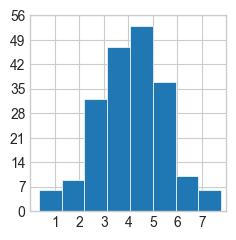

In [12]:
plt.style.use('_mpl-gallery')

# make data
np.random.seed(1)
x = 4 + np.random.normal(0, 1.5, 200)

# plot:
fig, ax = plt.subplots()

ax.hist(x, bins=8, linewidth=0.5, edgecolor="white")

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 56), yticks=np.linspace(0, 56, 9))

plt.show()

<Axes: >

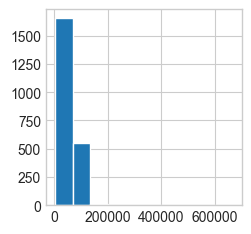

In [13]:
df['Income'].hist()

<Axes: xlabel='Education'>

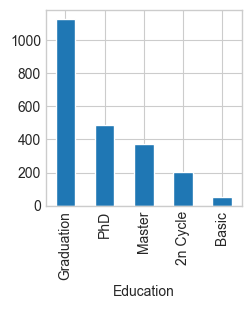

In [16]:
df['Education'].value_counts().plot(kind='bar')

In [19]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Income', y='Total_Spending')  # no cluster yet
sns.despine(left=True)
plt.show()

ValueError: Could not interpret value `Total_Spending` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

In [20]:
df.columns.tolist()

['ID',
 'Year_Birth',
 'Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Dt_Customer',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Z_CostContact',
 'Z_Revenue',
 'Response']

Calculer le total de dépense par client et le total d'achat par client puis visualiser la distribution : 

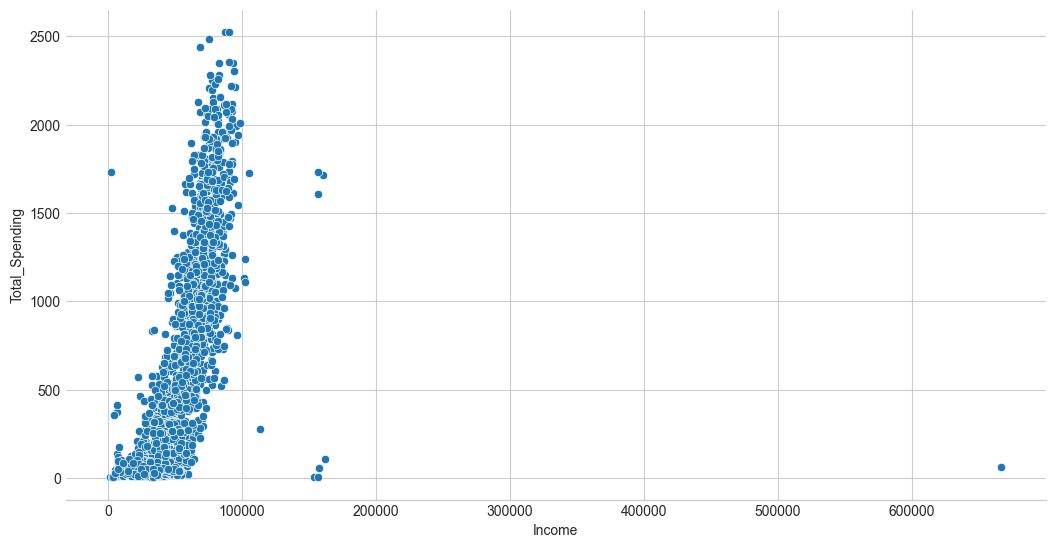

In [22]:
spending_cols = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
df['Total_Spending'] = df[spending_cols].sum(axis=1)

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Income', y='Total_Spending')
sns.despine(left=True)
plt.show()